#Project Bioinformatic
This project is a classification task, the dataset is filled with biomedical abstract text and we have to predict the class of a sentence.

#Installing and importing API's



In [1]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.3/en_core_sci_sm-0.5.3.tar.gz
import sklearn
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import numpy as np
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB

import spacy
import en_core_sci_sm
from gensim.models import KeyedVectors
from sklearn.ensemble import RandomForestClassifier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 24.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 919.6/919.6 kB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 3.4 MB/s eta 0:00:00
  Created wheel for en-core-sci-sm: filename=en_core_sci_sm-0.5.3-py3-none-any.whl size=14776165 sha256=cfbddf9e3d3cdf8f6bc8e0630242aa4102bfa5746d316f67ed3e6f9a0535b1b6
  Stored in directory: /root/.cache/pip/wheels/1a/27/08/5863b9fc5a65254f943eff433dd1e0fafc7ac4595be28d789d
Successfully built en-core-sci-sm
  Attempting uninstall: thinc
    Found existing installation: thinc 8.2.3
    Uninstalling thinc-8.2.3:
      Successfully uninstalled thinc-8.2.3
  Attempting uninstall: spacy
    Found existing installation: spacy 3.7.2
    Uninstalling spacy-3.7.2:
      Successfully uninstalled spacy-3.7.2
ERROR: pip's dependency resolv

Function needed for the project :

In [2]:
#Print element up to n of the list l
def show_top(n,l):
  for i in range(n):
    print(l[i])

# using spacy
nlp = spacy.load("en_core_sci_sm")
#function that gives me the lemma of each text given using scispacy
def spacy_tokenizer(text):
    #removing symbols
    symb = ['<','>','=','!','?','@',' ',',',';',':','(',')','-','/','*','"']
    #with stopwords
    tokens = nlp(text)
    return [token.lemma_ for token in tokens if not token.is_punct and not token.is_space and not token.is_stop and not token.pos_ == 'SYM' and not(token.lemma_ in symb) and not(len(token.lemma_)<2)]

#Converting a list of list of tokens to a list of text
def concat_token_to_text(l):
   tmp = []
   for i in range(len(l)):
      tmp.append(' '.join(l[i]))
   return tmp

#Calculate the number of elements for each class
def nb_each_classes(labels_list):
  #Computing all the differents classes of the labels_list
  classes = []
  nb_classes = []
  for i in labels_list:
    if not(i in classes):
      classes.append(i)
      nb_classes.append(0)
  #print(classes)
  #Computing all the number of elements for each classes
  for i in labels_list:
    for j in range(len(classes)):
      if classes[j] ==i:nb_classes[j]+=1
  return nb_classes

#Calculate the number of element for the label in the dataset
def nb_class(dataset,label):
  nb = 0
  for i in dataset:
    if(i==label):nb+=1
  return nb

#Balance the dataset according to the fewest element of a class from labels
def balance_xtrain(dataset,labels):
  nb_classes = nb_each_classes(labels)
  least_nb_class = min(nb_classes)
  Y=[]
  X=[]
  for i in range(len(labels)):
    if(nb_class(Y,labels[i])<least_nb_class):
      Y.append(labels[i])
      X.append(dataset[i])
  return X,Y

#Computing a weight for each class of labels_list
def weight_classes(labels_list):
  nb_classes = nb_each_classes(labels_list)
  num_el = 0
  for i in nb_classes: num_el+=i
  inv_weight = [num_el/(i*len(nb_classes)) for i in nb_classes]
  inv_weight.reverse()
  return inv_weight

#Concat all list of a list to a list
def convert_listlist_to_list (l):
  res = l[0]
  for i in range(1,len(l)):
    res += l[i]
  return res

#Converting l to a vocabulary of words
def convert_text_to_vocab(l):
  l = convert_listlist_to_list(l)
  res = []
  for i in range(len(l)):
    if (not(l[i] in res)):res.append(l[i])
  return res

/usr/local/lib/python3.10/dist-packages/spacy/language.py:2141: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


#Extraction and Data Preprocessing

What we did :
- Extracting dataset from the txt files
- Removing numerotations of each text
- Removing duplicate words for each text
- Spliting in data and labels
- Applying scispacy tools to remove punctuations, spaces, stopwords and symbols
- Converting words to their root with lemmatisation from scispacy
- Converting the data to the format sentences list : [['I am toto'], ['I eat cat'], ...] for the tfidf
- Balance the training data/weight classes
- Remove operators/symbols and characters
- Using a Vocabulary extracted from Xtrain for tfidf
- Changed the dataset with the numbers

Possible improvements/to explore :
- Handle with strange words without numbers : a@hp, @-d, ...
- Importing other scispacy models
- Optimize paramters for tfidf + models
- Manipulating and adding words that could be important in the dataset
- Deep learning models
- BERT
- Other embedding vectors



In [3]:
#Choosing hyperparameters for data préprocessing and extraction
max_train = 5000
max_test = max_train

Traning dataset case :

In [4]:
#training extraction
corpus_train = []
with open("train_200k_numb.txt", "r", encoding="utf-8") as fichier:
    for ligne in fichier:
        corpus_train.append(ligne.strip())  #strip() is used to separate each ligne with \n

#Removing numerotations of each text
corpus_train = [ sentence for sentence in corpus_train if sentence != '' and (not sentence.startswith('###'))]
#Removing text dupes
corpus_train = set(corpus_train)
#print(len(corpus_train),'\n',show_top(5,list(corpus_train)))

#Splitting labels, sentences
Xtrain_list = []
Ytrain_list = []
for sentence in corpus_train:
    l, s = sentence.split("\t")
    Xtrain_list += [s]
    Ytrain_list += [l]

#Lemmatization + NLP processing
lemm_Xtrain_list = [spacy_tokenizer(i) for i in Xtrain_list[0:max_train]]
#Lowercase each labels
Ytrain = [i.lower() for i in Ytrain_list[0:max_train]]
#Undersampling the Xtrain
lemm_Xtrain_list, Ytrain = balance_xtrain(lemm_Xtrain_list, Ytrain)
#Preprocessing for tfidf
corp_train = concat_token_to_text(lemm_Xtrain_list)

Validation dataset case :

In [5]:
#validation extraction
corpus_valid = []
with open("dev_200k_numb.txt", "r", encoding="utf-8") as fichier:
    for ligne in fichier:
        corpus_valid.append(ligne.strip())  #strip() is used to separate each ligne with \n

#Removing numerotations of each text
corpus_valid = [ sentence for sentence in corpus_valid if sentence != '' and (not sentence.startswith('###'))]
#Removing text dupes
corpus_valid = set(corpus_valid)
#print(len(corpus_valid),'\n',show_top(5,list(corpus_valid)))

#Splitting labels, sentences
Xvalid_list = []
Yvalid_list = []
for sentence in corpus_valid:
    l, s = sentence.split("\t")
    Xvalid_list += [s]
    Yvalid_list += [l]

#Lemmatization + NLP processing
lemm_Xvalid_list = [spacy_tokenizer(i) for i in Xvalid_list[0:max_train]]
#Lowercase each labels
Yvalid = [i.lower() for i in Yvalid_list[0:max_train]]
#Preprocessing for tfidf
corp_valid = concat_token_to_text(lemm_Xvalid_list)

Test dataset case :

In [6]:
#test extraction
corpus_test = []
# Ouvrir le fichier en mode lecture ("r" pour read)
with open("test_200k_numb.txt", "r", encoding="utf-8") as fichier:
    # Lire chaque ligne du fichier
    for ligne in fichier:
        # Afficher la ligne
        corpus_test.append(ligne.strip())  # strip() est utilisé pour supprimer les caractères de saut de ligne supplémentaires

#Removing numerotations of each text
corpus_test = [ sentence for sentence in corpus_test if sentence != '' and (not sentence.startswith('###'))]
#Removing text dupes
corpus_test = set(corpus_test)
#print(len(corpus_test),'\n',show_top(5,list(corpus_test)))

#Splitting labels, sentences
Xtest_list = []
Ytest_list = []
for sentence in corpus_test:
    l, s = sentence.split("\t")
    Xtest_list += [s]
    Ytest_list += [l]

#Lemmatization + NLP processing
lemm_Xtest = [spacy_tokenizer(i) for i in Xtest_list[0:max_test]]
#Lowercase each labels
Ytest = [i.lower() for i in Ytest_list[0:max_test]]
#Preprocessing for tfidf
corp_test = concat_token_to_text(lemm_Xtest)

Using tfidf and Vectorizer on the data :  

In [7]:
#vectorizer

#Parameters for tfidf which didn't improve the models
#vocabulary = convert_text_to_vocab(lemm_Xtrain_list), max_df=0.4, use_idf=True, smooth_idf=True, ngram_range=(1,2)
vectorizer = TfidfVectorizer(lowercase = True, stop_words = 'english', min_df = 0.001)
X_train_tfidf = vectorizer.fit_transform(corp_train)
X_test_tfidf = vectorizer.transform(corp_test)
Xvalid = vectorizer.transform(corp_valid)

vocab = vectorizer.get_feature_names_out()
docterm = pd.DataFrame(X_train_tfidf.todense(), columns=vocab)
print(X_train_tfidf.shape, X_test_tfidf.shape)

Xtrain = X_train_tfidf

(2175, 1939) (5000, 1939)


#Traning of our machine learning models :
We chose to use these classifications models : Knn, arbre de décision, SGDClassifier et MultinomialBN

Decision Tree model : https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [8]:
model_tree = tree.DecisionTreeClassifier(class_weight='balanced')
model_tree.fit(Xtrain,Ytrain)
prediction_tree = model_tree.predict(X_test_tfidf)

KNN model : https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier

In [9]:
acc_score = []
for i in range(1,40):
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(Xtrain,Ytrain)
  pred_i = knn.predict(Xvalid)
  acc_score.append(accuracy_score(Yvalid, pred_i))

Max accuracy score : 0.5692 at K = 38


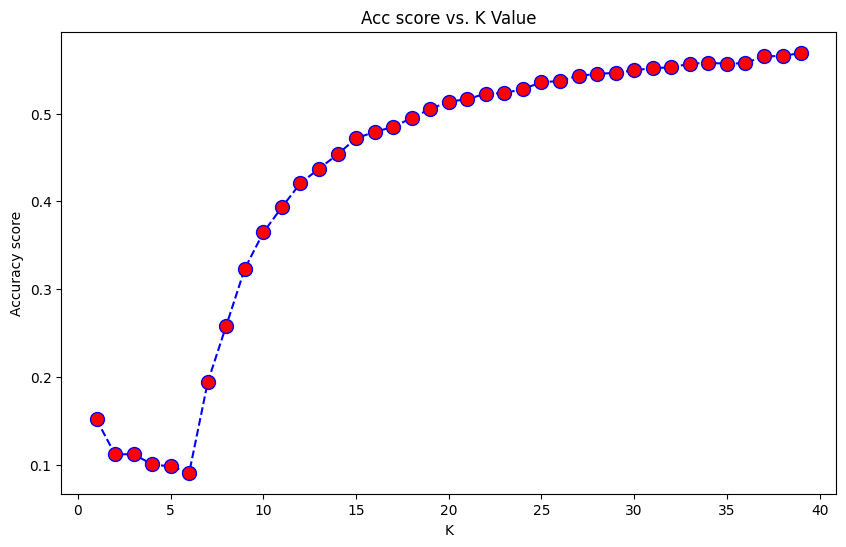

In [10]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),acc_score,color='blue', linestyle='dashed',
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Acc score vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy score')
print("Max accuracy score :",max(acc_score),"at K =",acc_score.index(max(acc_score)))


In [11]:
k = acc_score.index(max(acc_score))

model_knn = KNeighborsClassifier(k)
model_knn.fit(Xtrain,Ytrain)

prediction_knn = model_knn.predict(X_test_tfidf)

SGDClassifier model : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier

after tuning, we can use, the parameter where we got the best accuracy

In [12]:
#tuning for sgd
acc_score_sgd = []
for m_iter in [200, 500, 800 , 1000]:
    for l in ['hinge', 'perceptron']:
        sgd = Pipeline([("feature_scaling", StandardScaler(with_mean=False)), ("sgd", SGDClassifier(max_iter = m_iter, loss = l, eta0 = 1e-1,average = 5,  random_state=42, class_weight="balanced"))])
        sgd.fit(Xtrain,Ytrain)
        pred_i = sgd.predict(Xvalid)
        acc_score_sgd += [(accuracy_score(Yvalid, pred_i),m_iter,l)]
acc_score_sgd

#we can see that the loss of perceptron is the best, we can keep: max_iter = 500, loss = perceptron

[(0.5276, 200, 'hinge'),
 (0.5328, 200, 'perceptron'),
 (0.5276, 500, 'hinge'),
 (0.5328, 500, 'perceptron'),
 (0.5276, 800, 'hinge'),
 (0.5328, 800, 'perceptron'),
 (0.5276, 1000, 'hinge'),
 (0.5328, 1000, 'perceptron')]

In [13]:
sgd_pipe = Pipeline([("feature_scaling", StandardScaler(with_mean=False)), ("sgd", SGDClassifier(max_iter = 500,loss = 'perceptron', eta0 = 1e-3,average = 10,  random_state=42, class_weight="balanced"))])
sgd_pipe.fit(Xtrain,Ytrain)
prediction_sgd = sgd_pipe.predict(X_test_tfidf)


MultinomialBN model : https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB

In [14]:
#multinomial naïve bayes classification
wc = weight_classes(Ytrain)
wc = [wc[0],wc[4],wc[2],wc[1],wc[3]]

model_nb = MultinomialNB(class_prior=wc)
model_nb.fit(Xtrain,Ytrain)
prediction_nb = model_nb.predict(X_test_tfidf)

#Word vectors embedding

We download PubMed-w2v.bin a pretrained embedding medical word by Pubmed from this link : http://evexdb.org/pmresources/vec-space-models/
and after we load it

The file is too big to handle for google collab, we can see all the results in another file dowloadable here : https://drive.google.com/file/d/1eBsFfUnh4Mhl9OZGroeLz5Xg9bRynVbX/view?usp=share_link

#Results




##Comparison of the models performance :


In [15]:
#np.diag(cm_tree) #Diagonal of confusion matrix  = True Positive for each class
#np.sum(cm_tree,axis=0) #Column of confusion matrix  = True Positive + False Positive for each class
#np.sum(cm_tree,axis=1) #Line of confusion matrix True Positive + False Negative for each class

The score is :  0.482

For each class :
List of recalls :  [0.40598291 0.34370771 0.49218261 0.43703704 0.5613155 ] 
List of precisions :  [0.22144522 0.36182336 0.634166   0.27570093 0.6446863 ] 
List of F-measure :  [0.2865761689291101, 0.3525329632199861, 0.554225352112676, 0.3381088825214899, 0.600119189511323]

Overall Recall  : 0.44804515327554545 
Overall Précision : 0.4275643625258178 
Overall F-measure : 0.42631251125891706


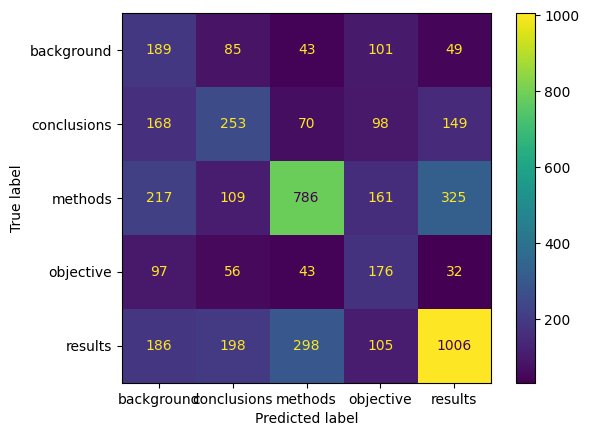

In [16]:
#Decision tree :

#Confusion matrix
cm_tree = confusion_matrix(Ytest, prediction_tree, labels=model_tree.classes_)
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=model_tree.classes_)
disp_tree.plot()

#Computing the numbers for calculating the differents metrics
recall_mod1 = (np.diag(cm_tree)+1) / (np.sum(cm_tree, axis = 1)+1)
precision_mod1 = (np.diag(cm_tree)+1) / (np.sum(cm_tree, axis = 0)+1)
f_measure_mod1 = [ (2*precision_mod1[i]*recall_mod1[i])/(recall_mod1[i]+precision_mod1[i]) for i in range(len(recall_mod1))]


print("The score is : ", model_tree.score(X_test_tfidf,Ytest))
print("\nFor each class :")
print("List of recalls : ",recall_mod1,"\nList of precisions : ", precision_mod1,"\nList of F-measure : ",f_measure_mod1)
print("\nOverall Recall  :",np.sum(recall_mod1)/len(recall_mod1),"\nOverall Précision :", np.sum(precision_mod1)/len(precision_mod1),"\nOverall F-measure :",np.sum(f_measure_mod1)/len(f_measure_mod1))

The precision, F-measure and recall are not good under 50%

Confusion matrix : There is a lot wrong prediction for the class : background, conclusion and objective.
As for the two classes result and method, there is quite good precision but still at least 1/5 wrong prediction.
It seems that there is a bias on these two classes.

After undersampling for balance the xtrain dataset, there is more prediction and the class background, conclusions and objective but for less right prediction on results and methods. There is still a bias on tehse 2 class.

After using weight_classes parameters, the result are similar with undersampling with a little improvement overall.


The score is :  0.5658

For each class :
List of recalls :  [0.62179487 0.30040595 0.65978737 0.25432099 0.64827202] 
List of precisions :  [0.24787053 0.52606635 0.67933033 0.31692308 0.75963423] 
List of F-measure :  [0.35444579780755175, 0.3824289405684755, 0.6694162436548223, 0.28219178082191776, 0.699548872180451]

Overall Recall  : 0.49691623967654985 
Overall Précision : 0.5059649020271478 
Overall F-measure : 0.4776063270066436


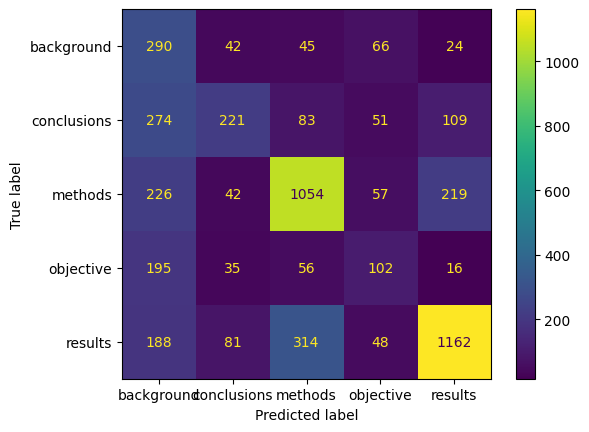

In [17]:
#KNN

#Confusion matrix
cm_knn = confusion_matrix(Ytest, prediction_knn, labels=model_knn.classes_)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=model_knn.classes_)
disp_knn.plot()

#Computing the numbers for calculating the differents metrics
recall_mod_knn = (np.diag(cm_knn)+1) / (np.sum(cm_knn, axis = 1)+1)
precision_mod_knn = (np.diag(cm_knn)+1) / (np.sum(cm_knn, axis = 0)+1)
f_measure_mod_knn = [ (2*precision_mod_knn[i]*recall_mod_knn[i])/(recall_mod_knn[i]+precision_mod_knn[i]) for i in range(len(recall_mod_knn))]


print("The score is : ", model_knn.score(X_test_tfidf,Ytest))
print("\nFor each class :")
print("List of recalls : ",recall_mod_knn,"\nList of precisions : ", precision_mod_knn,"\nList of F-measure : ",f_measure_mod_knn)
print("\nOverall Recall  :",np.sum(recall_mod_knn)/len(recall_mod_knn),"\nOverall Précision :", np.sum(precision_mod_knn)/len(precision_mod_knn),"\nOverall F-measure :",np.sum(f_measure_mod_knn)/len(f_measure_mod_knn))

Confusion matrix : The analysis is pretty much the same as for decision tree confusion matrix but with a much more bias on result and with a slight better recalls on methods and results.

After balancing the xtrain with undersampling, it is a little bit better but not enough. There is still a bias on methods and results.

No weight_classes can be added to knn.

The score is :  0.518

For each class :
List of recalls :  [0.33974359 0.38971583 0.57285804 0.40493827 0.59531773] 
List of precisions :  [0.22489392 0.36409608 0.6790215  0.22841226 0.74166667] 
List of F-measure :  [0.2706382978723404, 0.3764705882352941, 0.621438263229308, 0.2920747996438113, 0.660482374768089]

Overall Recall  : 0.460514691115878 
Overall Précision : 0.4476180838426053 
Overall F-measure : 0.4442208647497686


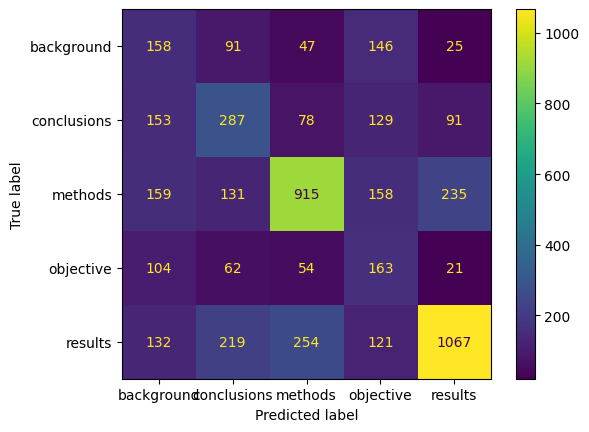

In [18]:
#SGDClassifier

#Confusion matrix
cm_sgd = confusion_matrix(Ytest, prediction_sgd, labels=sgd_pipe.classes_)
disp_sgd = ConfusionMatrixDisplay(confusion_matrix=cm_sgd, display_labels=sgd_pipe.classes_)
disp_sgd.plot()

#Computing the numbers for calculating the differents metrics
recall_mod1 = (np.diag(cm_sgd)+1) / (np.sum(cm_sgd, axis = 1)+1)
precision_mod1 = (np.diag(cm_sgd)+1) / (np.sum(cm_sgd, axis = 0)+1)
f_measure_mod1 = [ (2*precision_mod1[i]*recall_mod1[i])/(recall_mod1[i]+precision_mod1[i]) for i in range(len(recall_mod1))]


print("The score is : ", sgd_pipe.score(X_test_tfidf,Ytest))
print("\nFor each class :")
print("List of recalls : ",recall_mod1,"\nList of precisions : ", precision_mod1,"\nList of F-measure : ",f_measure_mod1)
print("\nOverall Recall  :",np.sum(recall_mod1)/len(recall_mod1),"\nOverall Précision :", np.sum(precision_mod1)/len(precision_mod1),"\nOverall F-measure :",np.sum(f_measure_mod1)/len(f_measure_mod1))

Confusion matrix : The difference here is that there is less bias on the class result, worse result on well prediction and more wrong prediction on the other class.

After undersampling, same as knn.

After weight_classes, the results are similar than decision tree, just a little bit worse.

The score is :  0.6366

For each class :
List of recalls :  [0.34615385 0.47767253 0.71419637 0.55555556 0.72798216] 
List of precisions :  [0.32206759 0.52923538 0.75529101 0.32234957 0.80369231] 
List of F-measure :  [0.3336766220391349, 0.5021337126600284, 0.7341690774670524, 0.4079782411604715, 0.7639660719508627]

Overall Recall  : 0.5643120935307361 
Overall Précision : 0.5465271719852263 
Overall F-measure : 0.5483847450555099


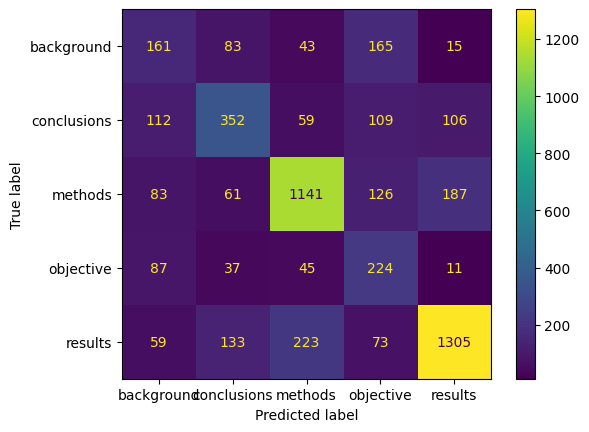

In [19]:
#MultinomialBN

#Confusion matrix
cm_nb = confusion_matrix(Ytest, prediction_nb, labels=model_nb.classes_)
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=model_nb.classes_)
disp_nb.plot()

#Computing the numbers for calculating the differents metrics
recall_mod1 = (np.diag(cm_nb)+1) / (np.sum(cm_nb, axis = 1)+1)
precision_mod1 = (np.diag(cm_nb)+1) / (np.sum(cm_nb, axis = 0)+1)
f_measure_mod1 = [ (2*precision_mod1[i]*recall_mod1[i])/(recall_mod1[i]+precision_mod1[i]) for i in range(len(recall_mod1))]


print("The score is : ", model_nb.score(X_test_tfidf,Ytest))
print("\nFor each class :")
print("List of recalls : ",recall_mod1,"\nList of precisions : ", precision_mod1,"\nList of F-measure : ",f_measure_mod1)
print("\nOverall Recall  :",np.sum(recall_mod1)/len(recall_mod1),"\nOverall Précision :", np.sum(precision_mod1)/len(precision_mod1),"\nOverall F-measure :",np.sum(f_measure_mod1)/len(f_measure_mod1))

Confusion matrix : The prediction are better here but with a much higher bias on the classes method and result.
There is no prediction made for objective.

After undersampling, a little bit worse results but more balanced prediction.

After weight_classes, it seems that the model does much better at predicting the minority class but lose significantly in predicting the majority class. The score didn't improve that much compared to undersampling.

Changing to the numb dataset, the result are a bit better. Improving about 3% (score 66%) for the score and overall metrics. The model did more correct prediction.

For the embedding vectors : the result is similar to the one we had with our machine learning model and tfidf preprocessing.
We still see the bias on prediction for the class result and methods.

##Discussion :

The score in general of all the models are bad even worse than random except for MultinomialNB where the precision is a little better (74%). It seems that the MultinomialNB model is a little bit better than the other for this task.
There is clearly a bias in the prediction in 2 classes, we can expect that the dataset is unbalanced.

After showing the sampling of each class, we found out that the dataset is in effect unbalanced. With an undersampling approach, we got a little bit worse results overall for the models but with a better balance on each right prediction class. One exception is MultinomialNB where the score is better of 2% and it does right prediction on all the class but the precision drop from 74% to 51% as for F-measure and recall increasing of 20%.

After weighting class, the score is pretty much similar as with undersampling. There was a little improvement while getting worse in predicting the majority class.

We did an embedding vectors with the mean and the sum but the score didn't improve compared to MultinomialNB.

The next step is either to optimize the hyperparameters of tfidf and each models or we can try another approach.

##Error analysis :

The precision is not good for the prediction of class objective, background and conclusions while for results and methods, it is quite good. It means that there is still a bias on predicting class.

Even after undersampling/weight classes, the score of the minority classes are bad falling under 30% while the majority class get all the credits. There is still a bias.
Clearly, the score is bad because of this bias, it is mandatory to fix it.

#Conclusion

We have preprocessed the dataset through different NLP techniques, undersampling, weightin classes and applied tfidf. We also use a embedding vectors based on the mean and sum between each words. Then we give these datas to differents models of machine learning.
The score we got are not satisfying, there is a lot of improvement which can be made but must to find out which one. The best score we obtained is with undersampling with MultinomialBN with a score of 64% with the numb dataset.

The first improvement that is necessary is to fix the unbalanced prediction made by all the models. We can increase the number of data and try to test other hyperparamaters on tfidf and/or models.
An other possibility is to try a different approach with deep learning models such as RNN or we can also try to find a different embedding word vectors representation.